In [5]:
import pickle
import json
import os
import numpy as np
from bitsets import bitset
from matplotlib import pyplot as plt
import itertools
from copy import deepcopy
import torch
import random
import sys
from numpy.linalg import norm

In [6]:
n_clients = 5
task = 'synthetic_classification_cnum5_dist11_skew1.0_seed0'
folder = '../fedtask/{}/record/'.format(task)
# prefix = 'fedavg_Mlr_R50_B10.0_E2_LR0.0100_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
#for iid case
prefix = 'fedavg_Mlr_R100_B10.0_E2_LR0.5000_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
DICT = dict()
files = os.listdir(folder)
files.sort(reverse=True)
for file in files:
    if file.startswith(prefix):
        with open(os.path.join(folder, file), 'r') as f:
            DICT[file.replace(prefix, '').replace('.json', '')] = np.array(json.load(f)['test_accuracy'])
DICT['0' * n_clients] = np.zeros(101)
CLIENTS_BITSET = bitset('clients_bitset', tuple(range(n_clients)))
ideal = list()
for client in range(n_clients):
    result = 0.0
    rest_clients = [client_ for client_ in range(n_clients) if client_ != client]
    for i in range(0, len(rest_clients) + 1):
        a_i = 0.0
        count_i = 0
        for subset in itertools.combinations(rest_clients, i):
            a_i += \
                (
                    DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][-1] - \
                    DICT[CLIENTS_BITSET(subset).bits()][-1]
                )
            count_i += 1
        a_i = a_i / count_i
        result += a_i
    result = result / len(range(n_clients))
    ideal.append(result)
ideal = np.array(ideal)

In [7]:
ideal

array([0.20628583, 0.19963116, 0.19720371, 0.19353753, 0.19147669])

In [8]:
duong = list()
duong_var = list()
for round_ in range(1, 51):
    # with open(os.path.join('../SV_result', task, 'duong-exact-ew5', 'Round{}.npy'.format(round_)), 'rb') as f:
    #     duong.append(pickle.load(f).tolist())
    # with open(os.path.join('../SV_result', task, 'duong-1-exact-5', 'Round{}.npy'.format(round_)), 'rb') as f:
    #     duong1.append(pickle.load(f).tolist())
    with open(os.path.join('../SV_result', task, 'duong-exact-new5', 'Round{}.npy'.format(round_)), 'rb') as f:
        duong.append(pickle.load(f).tolist())
    with open(os.path.join('../SV_result', task, 'duong-exact-new5', 'Var_round{}.npy'.format(round_)), 'rb') as f:
        duong_var.append(pickle.load(f).tolist())
duong = np.array(duong)
duong_var = np.array(duong_var)

In [9]:
sys.path.append('..')
from benchmark.synthetic_classification.model.lr import Model

In [10]:
global_model = Model()
first_global_model = Model()
next_global_model = Model()
final_model = Model()
local_model = Model()

global_path = '../checkpoint/synthetic_classification_cnum5_dist11_skew1.0_seed0/dist11/global'
local_path = '../checkpoint/synthetic_classification_cnum5_dist11_skew1.0_seed0/dist11/local'

In [11]:
angle = list()
cos_list = []
for i in range(50):
    first_global_model.load_state_dict(torch.load(os.path.join(global_path, f"round{0}/global_model.pt")))
    global_model.load_state_dict(torch.load(os.path.join(global_path, f"round{i}/global_model.pt")))
    next_global_model.load_state_dict(torch.load(os.path.join(global_path, f"round{i+1}/global_model.pt")))
    final_model.load_state_dict(torch.load(os.path.join(global_path, f"round{50}/global_model.pt")))
    
    grad_weight = next_global_model.state_dict()['layer.weight'] - global_model.state_dict()['layer.weight']
    grad_bias = next_global_model.state_dict()['layer.bias'] - global_model.state_dict()['layer.bias']
    grad_tensor = torch.concat((torch.flatten(grad_weight), torch.flatten(grad_bias)))
    
    final_grad_weight = final_model.state_dict()['layer.weight'] - first_global_model.state_dict()['layer.weight']
    final_grad_bias = final_model.state_dict()['layer.bias'] - first_global_model.state_dict()['layer.bias']
    final_grad_tensor = torch.concat((torch.flatten(final_grad_weight), torch.flatten(final_grad_bias)))
    
    for j in range(5):
        local_model.load_state_dict(torch.load(os.path.join(local_path, f'round{i+1}/local_model{j}.pt')))
        grad_weight = local_model.state_dict()['layer.weight'] - global_model.state_dict()['layer.weight']
        grad_bias = local_model.state_dict()['layer.bias'] - global_model.state_dict()['layer.bias']
        local_tensor = torch.concat((torch.flatten(grad_weight), torch.flatten(grad_bias)))
        
        local_cos = np.dot(final_grad_tensor, local_tensor)/(norm(final_grad_tensor) * norm(local_tensor))
        # local_cos = np.dot(grad_tensor, local_tensor)/(norm(grad_tensor) * norm(local_tensor))
        cos_list.append(local_cos)
    angle.append(cos_list)
    cos_list = []

In [12]:
duong

array([[0.20925988, 0.1601942 , 0.13934142, 0.13212572, 0.12704306],
       [0.18702951, 0.16559903, 0.16032751, 0.15653913, 0.15532818],
       [0.18702951, 0.17067058, 0.16609341, 0.16478247, 0.16471026],
       [0.18477759, 0.17605653, 0.17152935, 0.16971293, 0.17060725],
       [0.18537417, 0.17793628, 0.17656424, 0.17335355, 0.1739868 ],
       [0.18520308, 0.17976492, 0.17904835, 0.1759932 , 0.17713749],
       [0.18724948, 0.18098365, 0.17993379, 0.17935053, 0.17896169],
       [0.1863196 , 0.18310336, 0.18193685, 0.1805537 , 0.18029818],
       [0.18595743, 0.18446874, 0.18274674, 0.18186908, 0.1822357 ],
       [0.18644514, 0.1836844 , 0.18440652, 0.18368995, 0.18325112],
       [0.1872317 , 0.18537639, 0.18444319, 0.18473759, 0.18375439],
       [0.18739835, 0.18667622, 0.1854375 , 0.18552637, 0.18450429],
       [0.18686064, 0.18702173, 0.18622184, 0.18564969, 0.18532196],
       [0.18721393, 0.18803604, 0.18689175, 0.18529196, 0.18604186],
       [0.18965471, 0.18809381, 0.

In [13]:
duong_var = duong_var / 610
duong_var

array([[0.57488623, 0.38427142, 0.29883453, 0.25158726, 0.21880601],
       [0.32290955, 0.18617311, 0.13125687, 0.10321309, 0.08516594],
       [0.24579698, 0.13863387, 0.09698461, 0.07570206, 0.06319339],
       [0.20226804, 0.11363174, 0.07929754, 0.0618871 , 0.05329559],
       [0.17355016, 0.09796302, 0.06766784, 0.05388418, 0.04635499],
       [0.15354021, 0.08699911, 0.06108749, 0.04811683, 0.04207585],
       [0.13849918, 0.0794599 , 0.05552989, 0.04364978, 0.03872502],
       [0.12583527, 0.0727995 , 0.05119675, 0.04056126, 0.03626802],
       [0.11638691, 0.0678549 , 0.04771147, 0.03826776, 0.03439434],
       [0.10781044, 0.06391167, 0.04572915, 0.03597417, 0.0326166 ],
       [0.10081584, 0.06059762, 0.042787  , 0.03429485, 0.03128182],
       [0.09568511, 0.05779468, 0.04103123, 0.03288887, 0.02996003],
       [0.09029549, 0.05542361, 0.03980132, 0.03194922, 0.02871635],
       [0.08578468, 0.0531609 , 0.03801833, 0.03095281, 0.02841447],
       [0.08176019, 0.05104647, 0.

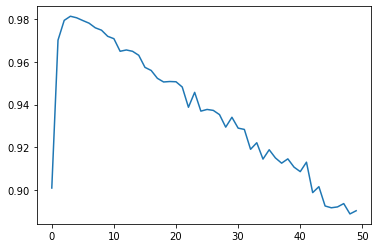

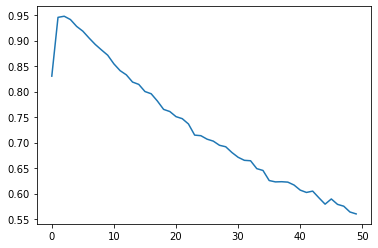

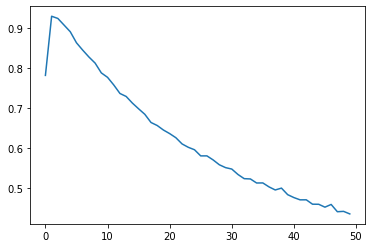

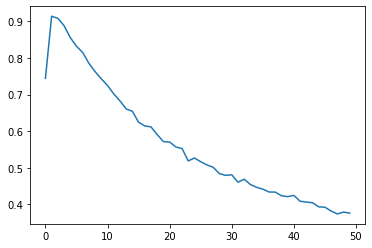

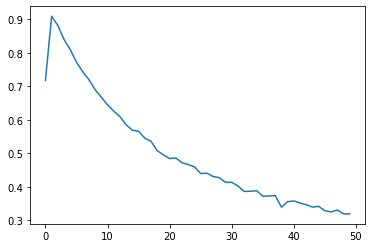

In [14]:
angle
angle_array = np.array(angle)
for i in range(5):
    plt.plot(angle_array[:, i])
    plt.show()

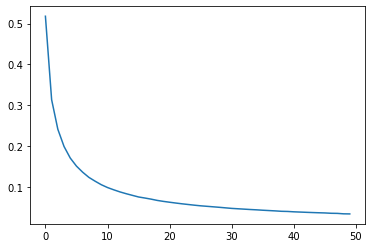

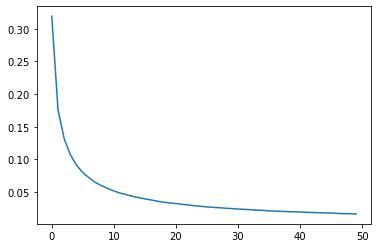

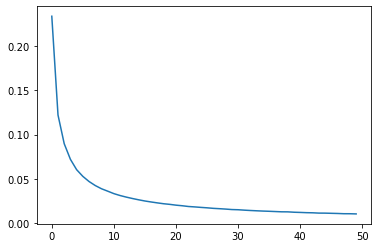

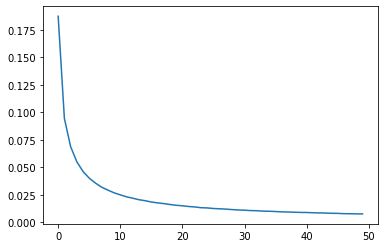

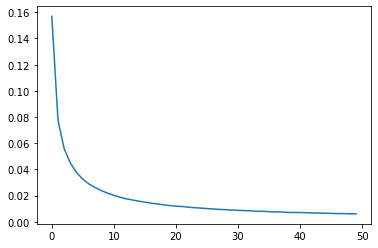

In [15]:
total = list()
for i in range(50):
    total.append(duong_var[i] * angle[i])
# total = np.array(total)
# ans = total.sum(axis=0)
# ans = ans / ans.sum()
total = [i.tolist() for i in total]
total = np.array(total)
# total
for i in range(5):
    plt.plot(total[:, i])
    plt.show()

In [16]:
ideal

array([0.20628583, 0.19963116, 0.19720371, 0.19353753, 0.19147669])

In [17]:
for i in range(50):
    ans = duong[i] * total[i]
ans

array([0.00639421, 0.0032558 , 0.00200411, 0.00145529, 0.00115237])

In [18]:
ans = ans / ans.sum()
ans

array([0.44834595, 0.22828813, 0.14052331, 0.10204146, 0.08080114])

In [19]:
len_data / len_data.sum()

NameError: name 'len_data' is not defined

In [ ]:
with open(os.path.join('../fedtask', task, 'data.json'), 'r') as f:
    data = json.load(f)

In [ ]:
len_data = np.array([len(data[client]['dtrain']['y']) for client in data['client_names']])

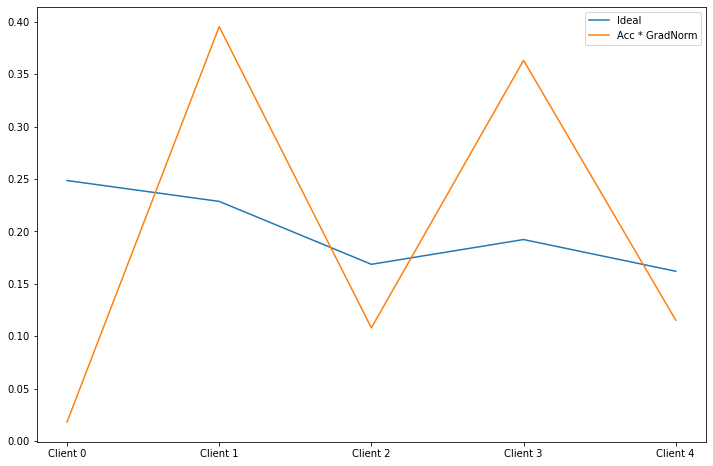

In [ ]:
x = ['Client {}'.format(i) for i in range(n_clients)]
plt.figure(figsize=(12, 8))
plt.plot(x, ideal / ideal.sum(), label='Ideal')
plt.plot(x, ans / ans.sum(), label='Acc * GradNorm')
# plt.plot(x, duong1.sum(axis=0) / duong1.sum(), label='GradNorm')
# plt.plot(x, len_data / len_data.sum(), label='Data')
plt.legend()
plt.show()